In [71]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch_directml
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.transforms import ToTensor

%matplotlib inline

In [72]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch_directml.device()
print(f"Using {device} device")

Using privateuseone:0 device


In [73]:
len(pd.read_csv("data/train.csv", header=None))

990000

In [74]:
class ImageColorizerDataset(Dataset):
    def __init__(self, root_dir, train=True, n_samples=None, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.annotations_file = pd.read_csv(os.path.join(root_dir, "train.csv" if train else "test.csv"), header=None)
        if n_samples:
            self.annotations_file = self.annotations_file.sample(n_samples)
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations_file)

    def __getitem__(self, idx: int):
        img_path = os.path.join(self.root_dir, "thumbs_gray", self.annotations_file.iloc[idx, 0])
        target_path = os.path.join(self.root_dir, "thumbs", self.annotations_file.iloc[idx, 0])

        img = read_image(img_path).numpy()
        target = read_image(target_path).numpy()
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            target = self.target_transform(target)

        return img.permute(1, 0, 2), target.permute(1, 0, 2)

In [75]:
train_data = ImageColorizerDataset(root_dir="./data", train=True, transform=ToTensor(), target_transform=ToTensor(), n_samples=100000)
test_data = ImageColorizerDataset(root_dir="./data", train=False, transform=ToTensor(), target_transform=ToTensor(), n_samples=1000)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Text(0.5, 1.0, 'Colorized Image')

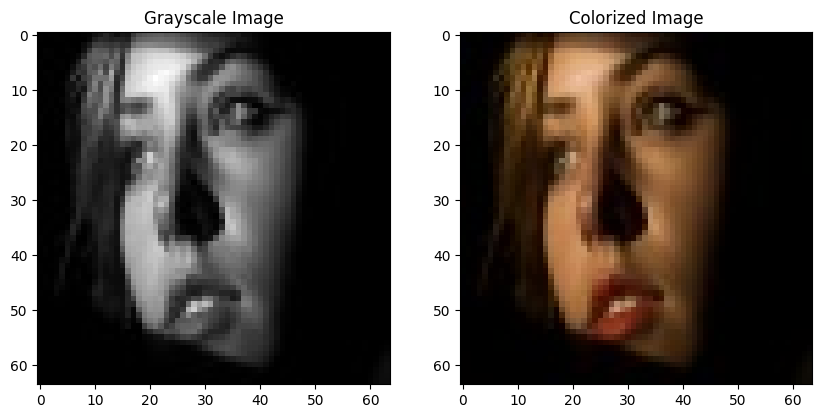

In [76]:
img, target = next(iter(train_dataloader))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[0].permute(2, 1, 0).squeeze(), cmap="gray")
ax[0].set_title("Grayscale Image")

ax[1].imshow(target[0].permute(2, 1, 0), interpolation="nearest")
ax[1].set_title("Colorized Image")

In [77]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch_directml.device()
print(f"Using {device} device")

Using privateuseone:0 device


In [78]:
class PrintLayer(nn.Module):
    def __init__(self, name=""):
        super(PrintLayer, self).__init__()
        self.name = name
    
    def forward(self, x):
        print(self.name, x.shape)
        return x

class ImageColorizerNetwork(nn.Module):
    def __init__(self):
        """Convolutional neural network for colorizing grayscale images.
        Takes a 1x64x64 image as input and outputs a 3x64x64 image.
        Multiple blocks of convolution->maxpool->batchnorm->relu are used.
        """
        super().__init__()
        self.conv_stack = nn.Sequential(

            # Downsample 
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # PrintLayer("First set"),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # PrintLayer("Second set"),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # PrintLayer("Third set"),

            # Upsample
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # PrintLayer("Fourth set"),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # PrintLayer("Fifth set"),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # PrintLayer("Sixth set"),

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # PrintLayer("Seventh set"),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),


            # PrintLayer("Eighth set"),
        )
    
    def forward(self, x):
        return self.conv_stack(x)


In [79]:
model = ImageColorizerNetwork().to(device)
print(model)

ImageColorizerNetwork(
  (conv_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Upsample(scale_factor=2.0, mode=nearest)
    (13): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [80]:
learning_rate = 1e-3
batch_size = 64
epochs = 32
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0

    for batch, (img, target) in enumerate(dataloader):
        img, target = img.to(device), target.to(device)

        # Compute prediction error
        pred = model(img)
        loss = loss_fn(pred, target)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(img)
            print(f"loss: {loss:>7f}  [{current:>6d}/{size:>6d}]")
    
    return train_loss / num_batches

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    with torch.no_grad():
        for img, target in dataloader:
            img, target = img.to(device), target.to(device)
            pred = model(img)
            test_loss += loss_fn(pred, target).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

    return test_loss

In [81]:
# wandb.init(project="image-colorizer", config={
#     "learning_rate": learning_rate,
#     "architecture": "CNN",
#     "batch_size": batch_size,
#     "epochs": epochs,
#     "loss_fn": "MSELoss",
#     "dataset": "MIRFLICKR-25k-thumbs"
# })

train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)

for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_losses[t] = train(train_dataloader, model, loss_fn, optimizer)
    test_losses[t] = test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1/32
-------------------------------
loss: 0.425354  [    0/100000]
loss: 0.062612  [  640/100000]
loss: 0.049426  [ 1280/100000]
loss: 0.046950  [ 1920/100000]
loss: 0.042726  [ 2560/100000]
loss: 0.040722  [ 3200/100000]
loss: 0.037731  [ 3840/100000]
loss: 0.031703  [ 4480/100000]
loss: 0.033685  [ 5120/100000]
loss: 0.036504  [ 5760/100000]
loss: 0.029141  [ 6400/100000]
loss: 0.029080  [ 7040/100000]
loss: 0.027993  [ 7680/100000]
loss: 0.027693  [ 8320/100000]
loss: 0.026825  [ 8960/100000]
loss: 0.025210  [ 9600/100000]
loss: 0.026581  [10240/100000]
loss: 0.024308  [10880/100000]
loss: 0.027328  [11520/100000]
loss: 0.028464  [12160/100000]
loss: 0.024535  [12800/100000]
loss: 0.028818  [13440/100000]
loss: 0.024685  [14080/100000]
loss: 0.022315  [14720/100000]
loss: 0.025760  [15360/100000]
loss: 0.023779  [16000/100000]
loss: 0.025314  [16640/100000]
loss: 0.023992  [17280/100000]
loss: 0.022735  [17920/100000]
loss: 0.021852  [18560/100000]
loss: 0.027155  [19200/1000

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predicted Image')

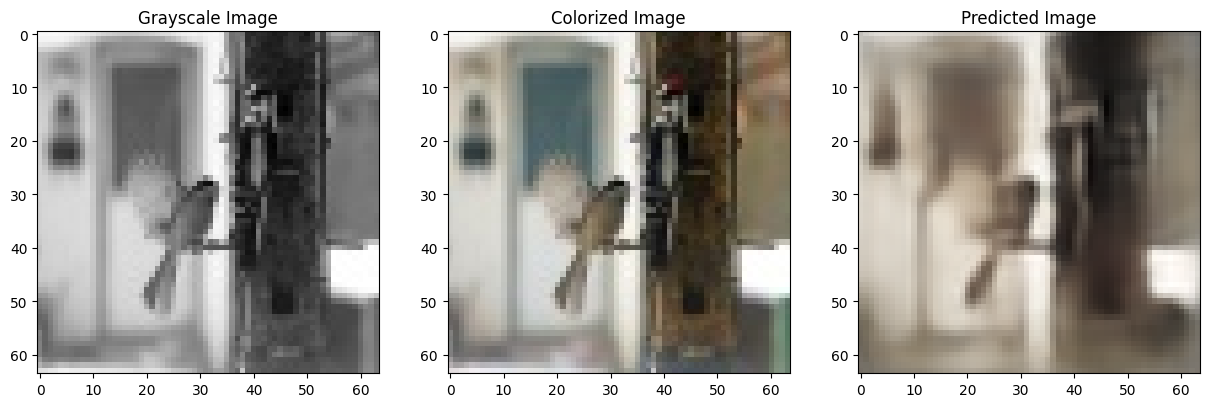

In [115]:
img, target = next(iter(train_dataloader))

pred = model(img.to(device))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img[0].permute(2, 1, 0).squeeze(), cmap="gray")
ax[0].set_title("Grayscale Image")

ax[1].imshow(target[0].permute(2, 1, 0), interpolation="nearest")
ax[1].set_title("Colorized Image")

ax[2].imshow(pred[0].permute(2, 1, 0).detach().cpu(), interpolation="nearest")
ax[2].set_title("Predicted Image")

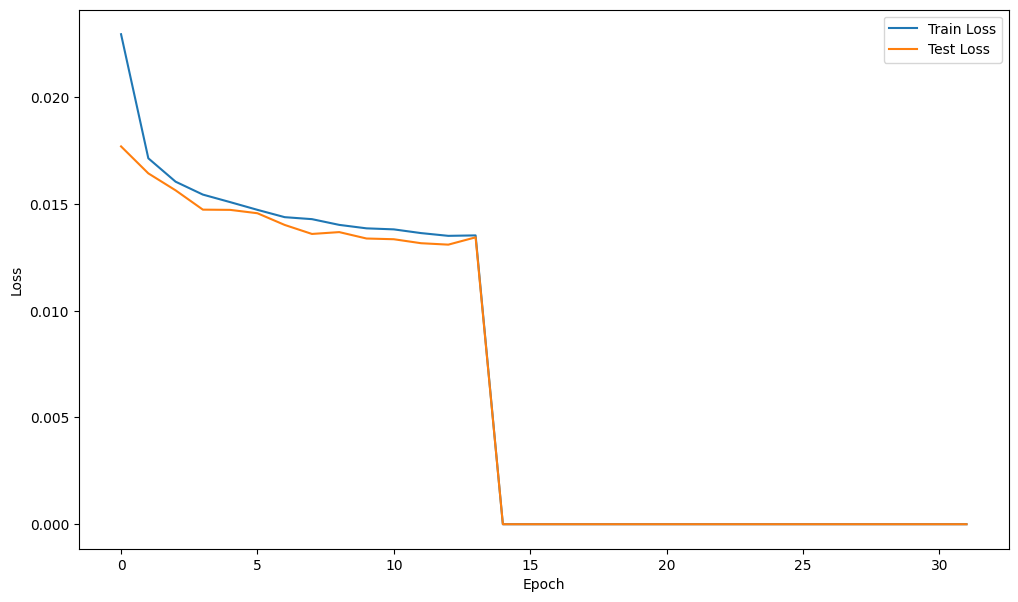

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(train_losses, label="Train Loss")
ax.plot(test_losses, label="Test Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

In [117]:
torch.save(model, "model.pt")
np.save("train_losses.npy", train_losses)
np.save("test_losses.npy", test_losses)